In [3]:
!pip install lmfit
!pip install requests
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

     |████████████████████████████████| 266kB 2.7MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 256kB 8.8MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=1c0d1a01b8c4543c03061b43ba93b063624ed8d96b7644c8306c265ad6b113a6
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=d3483b6dbdde5bb4355b7799bcfb1e33017469536487e3aac88f95d4292d6fbb
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
Successfully built lmfit asteval


In [7]:
def getCountryData(country,N):
  r = requests.get('https://api.covid19api.com/dayone/country/'+country)
  res=r.json()
  df=pd.DataFrame(res)
  df.to_csv('ma.csv',index=False)
  c=np.array(df['Confirmed'])
  a=np.array(df['Active'])
  r=np.array(df['Recovered'])
  d=np.array(df['Deaths'])
  #N=np.max(c)
  #N=21e6
  s=N-a-r-d
  y0=[s[0]-a[0],a[0],r[0],d[0]]
  data=np.array([s[1:],a[1:],r[1:],d[1:]])
  return y0,data
N=4e7
y0,data=getCountryData("MA",N)
print(y0)
  #p=1


[39999998.0, 1, 0, 0]


In [10]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma,p):
    S, I, R , D = y
    p=1
    dSdt = -beta * I *(S/ N)**p
    dIdt = beta * I * (S/ N)**p - (gamma +sigma) * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt


#Test de la fonction deriv
p=1
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1,1)



(-2.5e-07, -0.29999975000000006, 0.2, 0.1)

In [0]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    p= params["p"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma,p)).T

In [0]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    p= params["p"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n):
        root=np.sqrt((tau*(gamma+sigma)+1-tau*(beta/N)*(S[k]+I[k]))**2+4.*tau*(beta/N)*(tau*(gamma+sigma)+1.)*I[k])
        rest=(tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k]))
        den=(2.*tau*(beta/N)*(1.+tau*(gamma+sigma)))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[0:-1].tolist()
    I=I[0:-1].tolist()
    R=R[0:-1].tolist()
    D=D[0:-1].tolist()
    return np.array([S,I,R,D])

  

In [17]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('p', value=1,min=1, max=1e6)
fit_params.add('beta', value=0.2, min=0, max=4.0)
fit_params.add('gamma', value=0.02, min=0, max=1.0)
fit_params.add('sigma', value=0.01, min=0, max=1.0)
N=fit_params['N'].value
print('N:',N)
#Test de f
#x=np.linspace(1,2,10)


N: 40000000.0


CPU times: user 32.2 ms, sys: 2.14 ms, total: 34.3 ms
Wall time: 33.2 ms


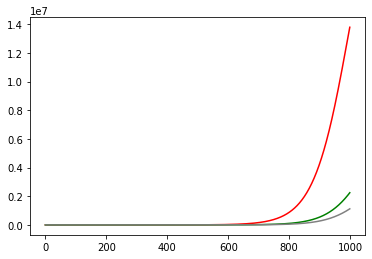

In [20]:
%%time
#Resolution using Fahd
tau = .1
x=np.linspace(tau,data.T.shape[0],int((data.T.shape[0])/tau))
y=fahd(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 25.1 ms


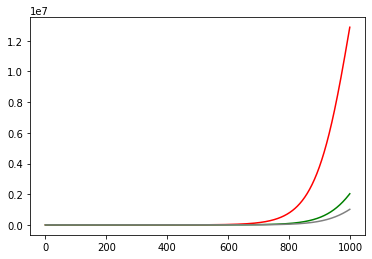

In [21]:
%%time
#Resolution using odint
p=1
y=f(fit_params,x,y0)

#Plot estimated data using odint
#plt.plot(y[0], label="Sr",color='blue')
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

In [0]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=x.size
    N= params["N"]
    pp= params["p"].value
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    P=np.ones(n+1)
    for i in range(tc,tc+eps+1):
      P[i]=1+(pp-1)*(i-tc)/eps 
    for i in range(tc+eps+1,n+1):
      P[i]=pp 
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=(S[0]/N)**(P[0]-1)
    for k in range(n):
        Err=1
        II=I[k]
        theta=(S[k]/N)**(P[k]-1)
        while Err>1e-10:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+(4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k]))
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))*theta
            III=(root-rest)/den
            SS=S[k]/(1.+(tau*(beta/N)*III*theta))
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta1=(SS/N)**(P[k+1]-1)
            #Err=abs(II-III)
            Err=abs(theta-theta1)
            II=III
            theta=theta1
            #print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        #print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

CPU times: user 49.5 ms, sys: 1.88 ms, total: 51.3 ms
Wall time: 54.3 ms


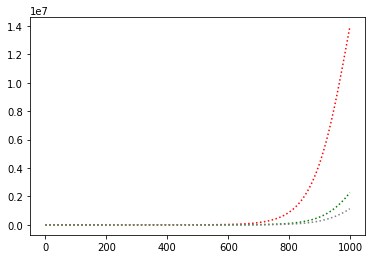

In [23]:
%%time
#Resolution using fahdFix
tau=0.1
tc=int(30/tau)#confinement
eps=10
n=x.size
#print(P)
yf=fahdFix(fit_params,x,y0)
#Plot estimated data using Mr karami's Algorithm
#plt.plot(yf[0],linestyle='dotted', label="Sr",color='blue')
plt.plot(yf[1],linestyle='dotted', label="Is",color='red')
plt.plot(yf[2],linestyle='dotted',label="Rs", color='green')
plt.plot(yf[3],linestyle='dotted',label="Ds", color='gray')

#plt.legend()

In [0]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    
    for i in range(ndata):
        resid[i, :] = data[i, :] - ret[i,:]
    return resid.flatten()

In [0]:

y0=[N-1,1,0,0]
tau = .01
tc= 30                #26   said depart #confinement
eps=8                #2 said 
n=data.T.shape[0]
X=np.linspace(tau,n,int(n/tau))
npArray = np.arange(0,int(n/tau) , int(1/tau))
yyy=X[npArray]

outf = minimize(objective, fit_params, method='Nelder-Mead',tol=1e-10, args=(fahdFix,yyy,data,y0))
out = minimize(objective, fit_params,  args=(f,yyy,data,y0))

#report_fit(out.params)
report_fit(outf.params)
y=f(out.params,yyy,[N-1,1,0,0])
yf=fahdFix(outf.params,yyy,[N-1,1,0,0])


plt.subplot(2, 2, 1)
plt.plot(data[0],label="Sr", color='blue')
#plt.plot(yyy,y[0], label="Sr",linestyle='dashed',color='blue')
plt.plot(yyy,yf[0],linestyle='dotted', label="Sr",color='blue')

plt.subplot(2, 2, 2)
plt.plot(data[1],label="Ir", color='red')
plt.plot(yyy,y[1], label="Is",linestyle='dashed',color='red')
plt.plot(yyy,yf[1],linestyle='dotted', label="Is",color='red')

plt.subplot(2, 2, 3)
plt.plot(data[2],label="Rr", color='green')
plt.plot(yyy,y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(yyy,yf[2],linestyle='dotted',label="Rs", color='green')

plt.subplot(2, 2, 4)
plt.plot(data[3],label="Dr", color='gray')
plt.plot(yyy,y[3],label="Ds",linestyle='dashed', color='gray')
plt.plot(yyy,yf[3],linestyle='dotted',label="Ds", color='gray')
print("===========================================")


#print(y.shape,yf.shape,data.shape)
plt.legend()




99
1.0579152888384609 4.956399705782881


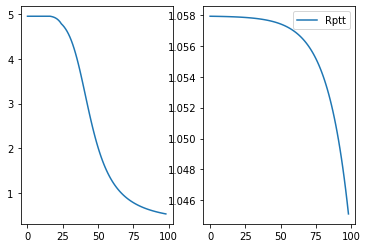

In [0]:
R00=out.params["beta"].value/(out.params["sigma"].value+out.params["gamma"].value)
R0=outf.params["beta"].value/(outf.params["sigma"].value+outf.params["gamma"].value)

n=yyy.size
print(n)
pp=outf.params["p"].value
P=np.ones(n)
for i in range(tc,tc+eps+1):
  P[i]=1+(pp-1)*(i-tc)/eps 
for i in range(tc+eps+1,n):
  P[i]=pp 
rt=R0*(yf[0]/N)**P
rtt=R00*(y[0]/N)**20
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(rt,label='Rpt')
plt.subplot(1, 2, 2)
plt.plot(rtt,label='Rptt')
print(R00, R0)
plt.legend()


[27999999. 27999998. 27999998. 27999998. 27999998. 27999998. 27999997.
 27999995. 27999994. 27999993. 27999983. 27999972. 27999971. 27999962.
 27999951. 27999937. 27999923. 27999904. 27999885. 27999857. 27999830.
 27999775. 27999725. 27999655. 27999598. 27999521. 27999444. 27999383.
 27999346. 27999292. 27999209. 27999081. 27998979. 27998880. 27998816.
 27998725. 27998626. 27998552. 27998455. 27998339. 27998237. 27998112.
 27997976. 27997717. 27997436. 27997315. 27997145. 27996954. 27996791.
 27996554. 27996432. 27996242. 27996103. 27995935.]


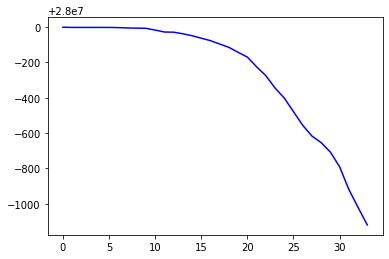

In [0]:
print(data[0,1:55])
plt.plot(data[0,1:35],label="Sr", color='blue')
#plt.plot(data[1,1:35],label="Ir", color='red')
#plt.plot(data[2,1:35],label="Rr", color='green')
#plt.plot(data[3,1:35],label="Dr", color='gray')

# Etape1:
Teste 1:  
presentation du caractère exponentielle dans les premiers 15 jours 
de l'épédimie  par paquet (Italy espagne france allemagne ) +(maroc algérie egypte afrique du sud) +(Chilie brazil mexique iran)

mettre en evidence le caractère exponenetille de l'épedemie







#Etape 2:
Test2: lancer SIR classique sur les premiers 15 jours, fitter sur les données, resuperer $ \alpha, \beta, et \gamma $ en suite tracer les courbes SIR et les SIRP en variant les p $p=10 , 100, 50000$
L'impact de $p$ est du confinement  et l et voir  l impact de la puissance 





# Etape3
Dans le test 3 on fit notre modèle et nous recuperons les nouveaux parametre $\alpha, \beta, \gamma et p $.
Nous fittons egalement SIR.

Comparer d'abord fitting de notre modele et du modèle SIR.
mettre en evidence que le fitting avec notre modèle donne meilleure resultasts vu qu il prend en considération la distanciation social( indicateur de fitting).
(Donner plus d'importance et donnée recente)


Tracer le $R_p(t)$ pour chaque pays 

Mesuré l'impact du confinement en comparant notre modèle  avec (SIR avec les parametres $(\alpha, \beta, \gamma)$ de l'etape 2)
-